In [1]:
p <- c("vegan","ade4","reshape2","ggplot2","pheatmap","dplyr","randomForest", "vegan", "ape",
       "cluster", "clusterSim", "plotly", "corrplot", "pROC", "cowplot", "gridExtra", "grid")
usePackage <- function(p) {
  if (!is.element(p, installed.packages()[,1]))
    install.packages(p, dep=TRUE, repos="https://cloud.r-project.org/")
  suppressWarnings(suppressMessages(invisible(require(p, character.only=TRUE))))
}
invisible(lapply(p, usePackage))
source("metabo_util.R")
#-------------------------------
setwd('~/MyProjects/SoH_project/multi-omics')


In [2]:
outpath="PERMANOVA_out/"
dir.create(outpath)

Warning message in dir.create(outpath):
“'PERMANOVA_out' already exists”

## Data input

In [3]:
filename1<-"PlaqueMS275.txt"
prefix1<-"metabolomics"
metadata.filename1<-"PlaqueMS275_Map.txt"
filename2="SoH261.taxa.genus.Abd.xls"
prefix2<-"microbiome-genus"
metadata.filename2<-"SoH261_Map.txt"
filename3<-"SoH192_cytokines.txt"
prefix3<-"cytokines"
metadata.filename3<-"SoH192_Map.txt"

outputPath<-"./PERMANOVA_out/"
dir.create(outputPath)
f1<-read.table(filename1,header=TRUE,sep="\t",row.names=1, quote=""); f1<-f1[order(rownames(f1)), ]
f2<-read.table(filename2,header=TRUE,sep="\t",row.names=1); f2<-f2[order(rownames(f2)), ]
f3<-read.table(filename3,header=TRUE,sep="\t",row.names=1); f3<-f3[order(rownames(f3)), ]
m1<-read.table(metadata.filename1,header=T,sep="\t",row.names=1); m1<-m1[order(rownames(m1)), ]
m2<-read.table(metadata.filename2,header=T,sep="\t",row.names=1); m2<-m2[order(rownames(m2)), ]
m3<-read.table(metadata.filename3,header=T,sep="\t",row.names=1); m3<-m3[order(rownames(m3)), ]

cat("The order of samples in the metabolome data and metadata are equal:", all.equal(rownames(f1), rownames(m1)), "\n")
cat("The order of samples in the microbiome data and metadata are equal:", all.equal(rownames(f2), rownames(m2)), "\n")
cat("The order of samples in the cytokines data and metadata are equal:", all.equal(rownames(f3), rownames(m3)))


Warning message in dir.create(outputPath):
“'./PERMANOVA_out' already exists”

The order of samples in the metabolome data and metadata are equal: TRUE 
The order of samples in the microbiome data and metadata are equal: TRUE 
The order of samples in the cytokines data and metadata are equal: TRUE

In [4]:
cat("# of samples in the metabolome: ", nrow(f1), "\n")
cat("# of samples in the microbiome: ", nrow(f2), "\n")
cat("# of samples in the cytokines: ", nrow(f3), "\n")

# of samples in the metabolome:  275 
# of samples in the microbiome:  261 
# of samples in the cytokines:  192 


In [5]:
paste0(colnames(f3), collapse=", ")

[1] "MIP.1_beta, IL.6, IFN.gamma, IL.1ra, IL.5, GM.CSF, TNF.alpha, RANTES, IL.2, IL.1_beta, Eotaxin, Basic_FGF, VEGF, PDGF.BB, IP.10, IL.13, IL.4, MCP.1, IL.8, MIP.1_alpha, IL.10, G.CSF, IL.15, IL.7, IL.12p70, IL.17A, IL.9"

## The distribution of hosts and samples and measurement types

In [6]:
md1<-data.frame(measurement_type="metabolome", m1)
md2<-data.frame(measurement_type="microbiome", m2)
md3<-data.frame(measurement_type="cytokines", m3)

In [7]:
head(md1)
head(md2)
head(md3)

,measurement_type,Group,Visit,Host_ID,Timepoint,Day,Bleeding,Mazza,Halimeter,Age,Gender,Smoking,Remark,Delta_R30,Delta_R70,Delta_R120,sps
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
H3003_0,metabolome,High_bleeder,T4,H3003,DAY0,0,1,1.0179,171,38,F,N,CSD2017073_3003_DAY0,35,1,0,0
H3003_1,metabolome,High_bleeder,T5,H3003,DAY01,1,0,1.0000,141,38,F,N,CSD2017073_3003_DAY01,128,13,0,1
H3003_14,metabolome,High_bleeder,T8,H3003,DAY14,14,2,1.0357,110,38,F,N,CSD2017073_3003_DAY14,20,2,0,0
H3003_21b,metabolome,High_bleeder,T1,H3003,DAY-21,-21,15,1.3571,94,38,F,N,CSD2017073_3003_DAY_21,105,25,8,1
H3003_28,metabolome,High_bleeder,T9,H3003,DAY28,28,2,1.0536,120,38,F,N,CSD2017073_3003_DAY28,30,5,0,0
H3003_3,metabolome,High_bleeder,T6,H3003,DAY03,3,1,1.0357,87,38,F,N,CSD2017073_3003_DAY03,39,4,0,0


,measurement_type,Host_ID,PNO_identity,Plaque,Timepoint,Day,Visit,Plaque_weight,Bleeding,Mazza,Halimeter,Group_short,Group,Age,Gender,Smoking,Delta_R30,Delta_R70,Delta_R120,sps
,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<int>,<dbl>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
H3003_0,microbiome,H3003,3003,PlaqueA,DAY0,0,T4,0.0035,1,1.0179,171,H,High_bleeder,38,F,N,35,1,0,0
H3003_1,microbiome,H3003,3003,PlaqueA,DAY01,1,T5,0.0081,0,1.0000,141,H,High_bleeder,38,F,N,128,13,0,1
H3003_14,microbiome,H3003,3003,PlaqueA,DAY14,14,T8,0.0072,2,1.0357,110,H,High_bleeder,38,F,N,20,2,0,0
H3003_21b,microbiome,H3003,3003,PlaqueA,DAY_21,-21,T1,0.0110,15,1.3571,94,H,High_bleeder,38,F,N,105,25,8,1
H3003_28,microbiome,H3003,3003,PlaqueA,DAY28,28,T9,0.0085,2,1.0536,120,H,High_bleeder,38,F,N,30,5,0,0
H3003_3,microbiome,H3003,3003,PlaqueA,DAY03,3,T6,0.0048,1,1.0357,87,H,High_bleeder,38,F,N,39,4,0,0


,measurement_type,Group,Visit,Host_ID,Timepoint,Day,Bleeding,Mazza,Halimeter,Age,Gender,Smoking,Plate_loc,Batch
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
H3003_0,cytokines,High_bleeder,T4,H3003,DAY0,0,1,1.0179,171,38,F,N,1H7,1st_P1
H3003_21b,cytokines,High_bleeder,T1,H3003,DAY-21,-21,15,1.3571,94,38,F,N,1B11,1st_P1
H3003_28,cytokines,High_bleeder,T9,H3003,DAY28,28,2,1.0536,120,38,F,N,1.00E+05,1st_P2
H3003_3,cytokines,High_bleeder,T6,H3003,DAY03,3,1,1.0357,87,38,F,N,1D9,2nd
H3003_7,cytokines,High_bleeder,T7,H3003,DAY07,7,0,1.0000,243,38,F,N,1D6,2nd
H3007_0,cytokines,High_bleeder,T4,H3007,DAY0,0,1,1.0179,98,37,F,N,1A6,1st_P1


In [8]:
library(plyr)
mylist <- list( one=md1, two=md2, three=md3 )
comb_md<-join_all( mylist, type="full") 


Joining by: measurement_type, Group, Visit, Host_ID, Timepoint, Day, Bleeding, Mazza, Halimeter, Age, Gender, Smoking, Delta_R30, Delta_R70, Delta_R120, sps
Joining by: measurement_type, Group, Visit, Host_ID, Timepoint, Day, Bleeding, Mazza, Halimeter, Age, Gender, Smoking


In [9]:
str(comb_md)

'data.frame':	728 obs. of  23 variables:
 $ measurement_type: Factor w/ 3 levels "metabolome","microbiome",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Group           : Factor w/ 2 levels "High_bleeder",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Visit           : Factor w/ 7 levels "T1","T4","T5",..: 2 3 6 1 7 4 5 2 3 6 ...
 $ Host_ID         : Factor w/ 40 levels "H3003","H3007",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ Timepoint       : Factor w/ 8 levels "DAY-21","DAY0",..: 2 3 6 1 7 4 5 2 3 6 ...
 $ Day             : int  0 1 14 -21 28 3 7 0 1 14 ...
 $ Bleeding        : int  1 0 2 15 2 1 0 1 2 6 ...
 $ Mazza           : num  1.02 1 1.04 1.36 1.05 ...
 $ Halimeter       : int  171 141 110 94 120 87 243 98 104 396 ...
 $ Age             : int  38 38 38 38 38 38 38 37 37 37 ...
 $ Gender          : Factor w/ 2 levels "F","M": 1 1 1 1 1 1 1 1 1 1 ...
 $ Smoking         : Factor w/ 2 levels "N","Y": 1 1 1 1 1 1 1 1 1 1 ...
 $ Remark          : Factor w/ 275 levels "CSD2017073_3003_DAY_21",..: 2 3 6 1 7 4 5 9 10 13 ...
 $

In [10]:
with(comb_md, table(measurement_type, Host_ID))

                Host_ID
measurement_type H3003 H3007 H3008 H3012 H3015 H3016 H3034 H3046 H3047 H3052
      metabolome     7     7     7     7     7     7     5     7     7     7
      microbiome     7     7     7     7     7     7     5     7     7     7
      cytokines      5     5     5     5     5     5     3     5     5     5
                Host_ID
measurement_type H3055 H3056 H3204 H5007 H5076 H5103 H5238 H7055 H8003 H8430
      metabolome     7     7     7     7     7     7     7     7     5     7
      microbiome     7     7     7     7     7     7     7     7     5     0
      cytokines      5     5     5     5     5     5     5     5     4     3
                Host_ID
measurement_type L3017 L3018 L3025 L3032 L3045 L3051 L5041 L5059 L5065 L5085
      metabolome     7     7     7     7     7     7     7     7     7     7
      microbiome     7     7     7     7     7     7     7     7     7     7
      cytokines      5     5     5     5     5     5     5     5     5     5
    

In [11]:
detach("package:plyr")
library("dplyr")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


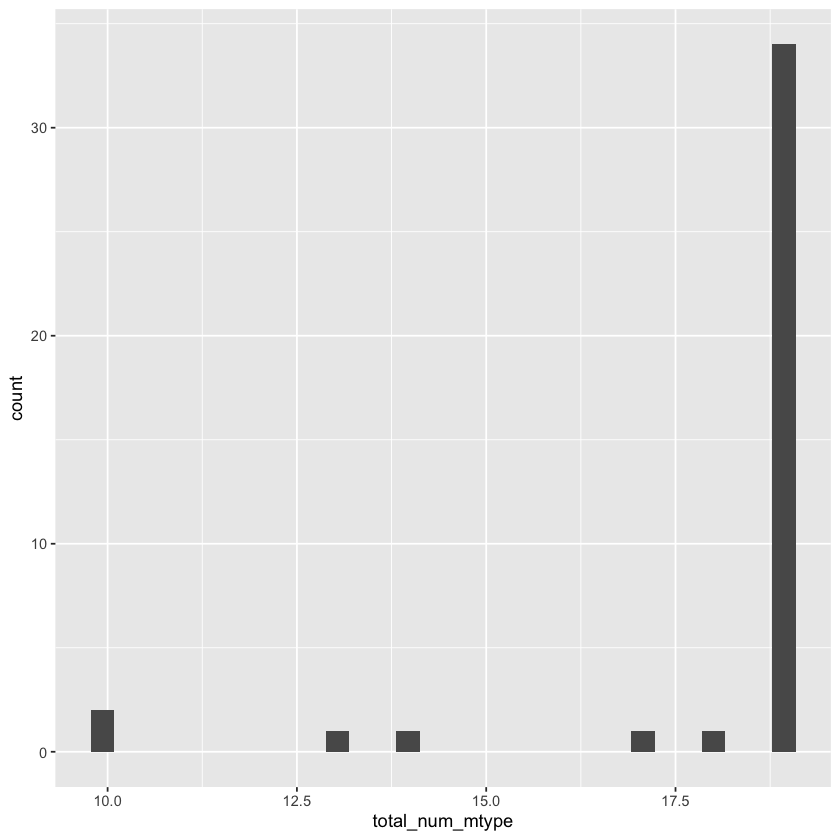

In [12]:
comb_md %>% group_by(Host_ID) %>% 
summarise(total_num_mtype = length(measurement_type), 
          ave_num_mtype = length(measurement_type)/3, 
          Day = length(unique(Day))) %>%
ggplot(aes(x=total_num_mtype)) + geom_histogram()

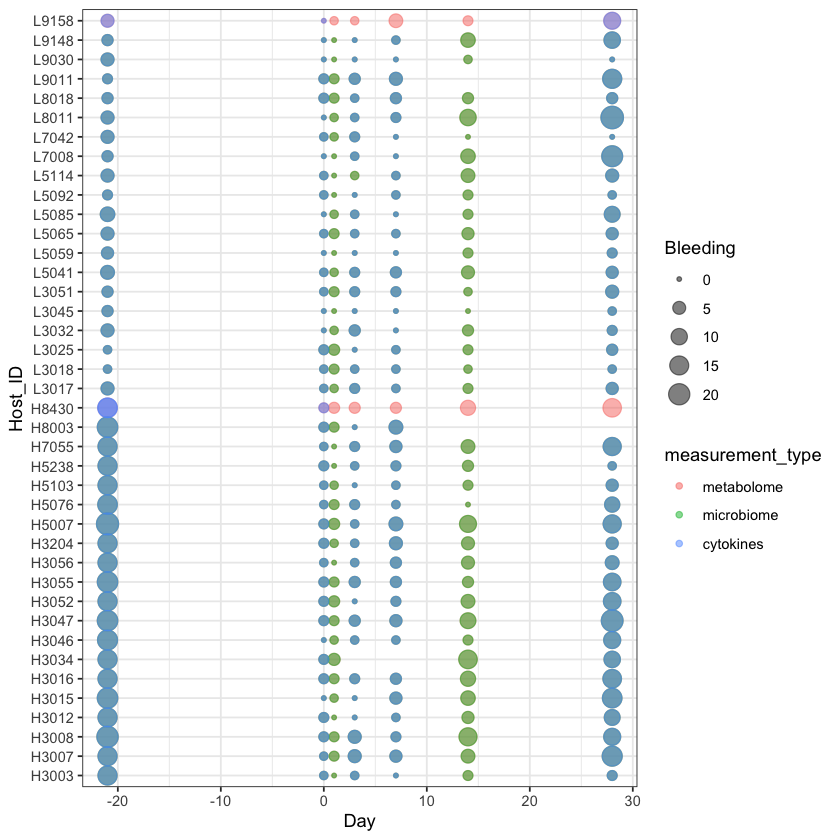

In [13]:
p<-ggplot(comb_md, aes(x=Host_ID, y=Day)) + 
geom_point(aes(size=Bleeding, color=measurement_type), alpha=0.5) + 
coord_flip() + 
#facet_wrap(~ measurement_type) + 
theme_bw()
p
ggsave(filename=paste(outputPath,"/hosts_VS_time_by_measurements_Group.pdf",sep=""), plot=p, width=10, height=6)

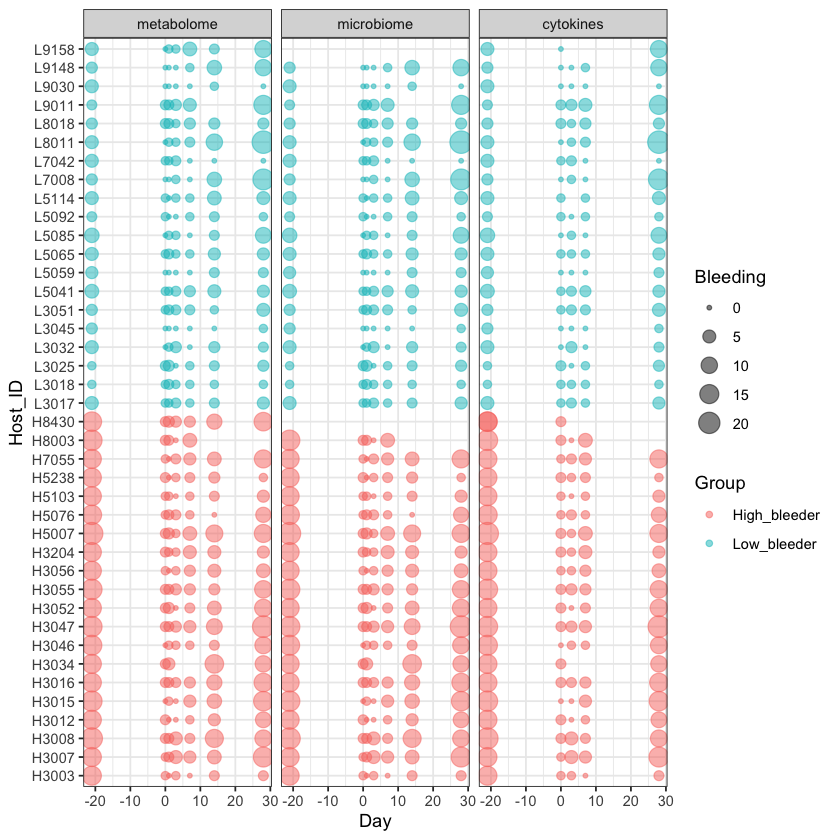

In [14]:
p<-ggplot(comb_md, aes(x=Host_ID, y=Day, color=Group)) + 
geom_point(aes(size=Bleeding), alpha=0.5) + 
coord_flip() + 
facet_wrap(~ measurement_type) + 
theme_bw()
p
ggsave(filename=paste(outputPath,"/hosts_VS_time_by_measurements_Group.facets.pdf",sep=""), plot=p, width=10, height=6)

## To identify intersected sample IDs

The order of samples in the metabolome data and metadata are equal: TRUE 
The order of samples in the microbiome data and metadata are equal: TRUE 


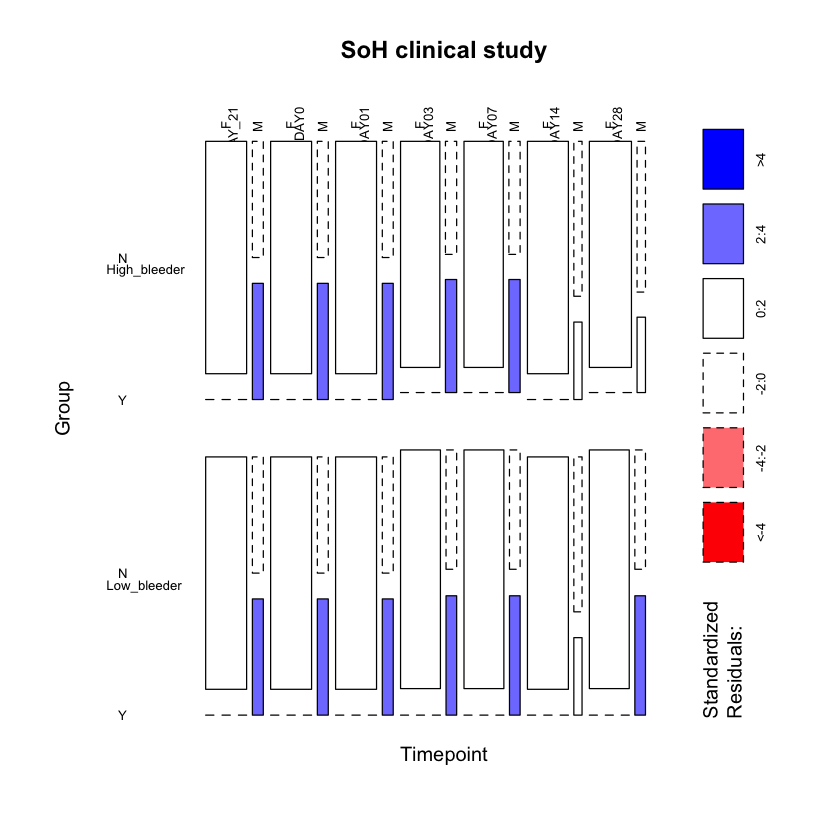

In [15]:

Shared_SampleIDs<-intersect(rownames(f1), rownames(f2))
f1_s<-f1[Shared_SampleIDs,]; 
m1_s<-m1[Shared_SampleIDs,]; 
cat("The order of samples in the metabolome data and metadata are equal:", all.equal(rownames(f1_s), rownames(m1_s)), "\n")
f2_s<-f2[Shared_SampleIDs,]; 
m2_s<-m2[Shared_SampleIDs,]; 
cat("The order of samples in the microbiome data and metadata are equal:", all.equal(rownames(f2_s), rownames(m2_s)), "\n")
library("graphics")
dt<-table(m2[, c("Timepoint", "Group", "Gender", "Smoking")])
mosaicplot(dt, shade = TRUE, las=2, main = "SoH clinical study")

## Clinical measurements

In [34]:
clinical_md<-"all_clincal_metadata.txt"
cmd<-read.table(clinical_md,header=T,sep="\t",row.names=1,comment.char = ""); cmd<-cmd[order(rownames(cmd)), ]
dim(cmd)

[1] 347  15

In [17]:
cmd %>% group_by(Timepoint) %>% summarise(Bleeding_mean=mean(Bleeding))

Timepoint,Bleeding_mean
<fct>,<dbl>
DAY-07,2.897436
DAY-14,3.484848
DAY-21,10.150000
DAY0,1.100000
DAY01,1.275000
DAY03,1.358974
DAY07,2.128205
DAY14,4.578947
DAY28,8.205128


In [18]:
levels(cmd$Timepoint)

[1] "DAY-07" "DAY-14" "DAY-21" "DAY0"   "DAY01"  "DAY03"  "DAY07"  "DAY14" 
[9] "DAY28"

In [19]:
cmd$Timepoint<-factor(cmd$Timepoint, levels=c('DAY-21', 'DAY-14', 'DAY-07', 'DAY0','DAY01','DAY03','DAY07','DAY14','DAY28'), ordered = TRUE)

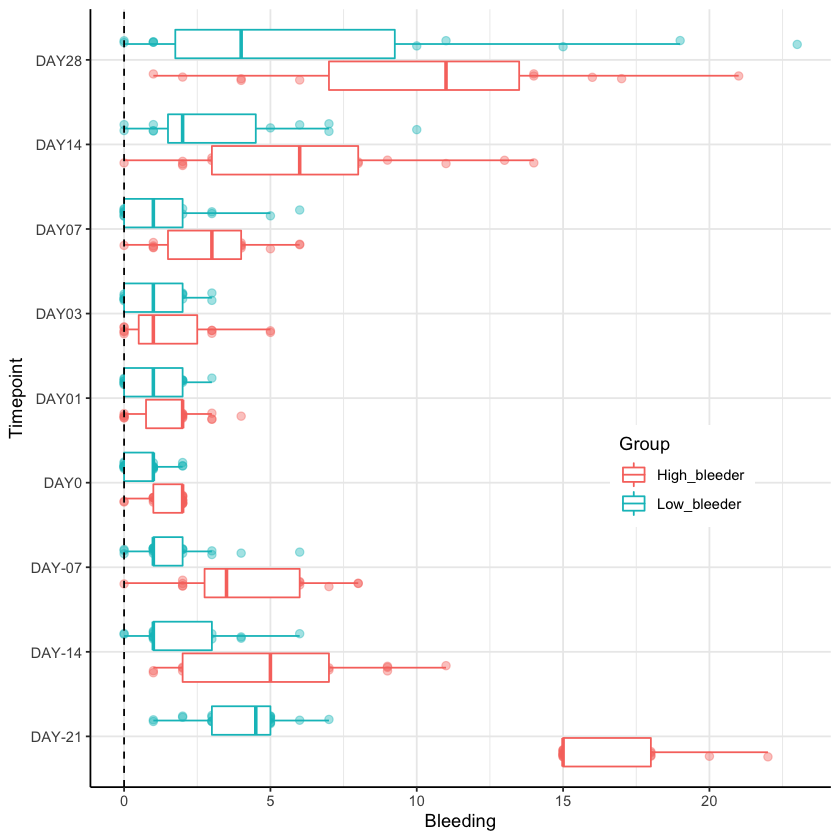

In [20]:
c_bp<-ggplot(cmd, aes(x=Timepoint, y=Bleeding)) +
    geom_jitter(aes(color=Group), position=position_jitterdodge(jitter.width= 0.2,dodge.width = 0.8),size=2,alpha=0.4) +
    geom_boxplot(aes(color=Group), outlier.shape = NA) + 
    #scale_color_manual(values=c("", ""))+
    #geom_point(aes(fill=Group), pch = 21, position = position_dodge(width = 0.8), size=1,alpha=0.6)+
    ylab("Bleeding")+
    coord_flip()+
    geom_hline(yintercept=0, linetype="dashed")+
    theme_bw()+
    theme(
        axis.line = element_line(color="black"),
        strip.background = element_rect(colour = "white"),
        panel.border = element_blank())+
theme(legend.position=c(0.8, 0.4))
#theme(legend.position="none")
c_bp
ggsave(filename=paste(outpath,"/Bleeding_by_Group.pdf",sep=""), plot=c_bp, width=3, height=5)

In [21]:
install.packages("ggridges")
library(ggridges)


Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Picking joint bandwidth of 1.01
Picking joint bandwidth of 1.01


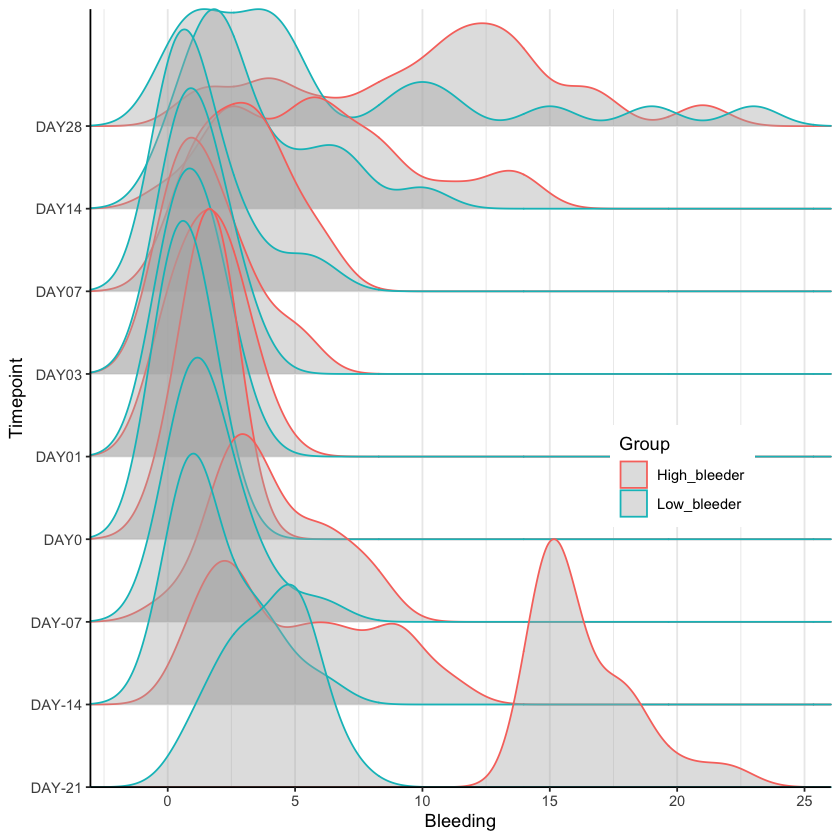

In [22]:
c_rg<-ggplot(cmd, aes(x=Bleeding, y=Timepoint, color=Group)) +
  geom_density_ridges(scale = 4, alpha=0.4) + 
  scale_y_discrete(expand = c(0, 0)) +     # will generally have to set the `expand` option
  scale_x_continuous(expand = c(0, 0)) +   # for both axes to remove unneeded padding
  coord_cartesian(clip = "off") + # to avoid clipping of the very top of the top ridgeline
  theme_ridges() +
  theme_bw()+
    theme(
        axis.line = element_line(color="black"),
        strip.background = element_rect(colour = "white"),
        panel.border = element_blank())+
theme(legend.position=c(0.8, 0.4))
c_rg
ggsave(filename=paste(outpath,"/Bleeding_by_Group.ggridges.pdf",sep=""), plot=c_rg, width=3, height=5)

## The metadata columns shared by multi-omics data

In [23]:
all_group<-intersect(intersect(colnames(m1), colnames(m2)), colnames(m3))
all_group

[1] "Group"     "Visit"     "Host_ID"   "Timepoint" "Day"       "Bleeding" 
 [7] "Mazza"     "Halimeter" "Age"       "Gender"    "Smoking"

## PERMANOVA

In [24]:
#--------------------------------------------------
# Distance matrix
#--------------------------------------------------
dm_f1<-vegdist(f1, method = "bray")
dm_f2<-vegdist(f2, method = "bray")
dm_f3<-vegdist(f3, method = "euclidean")

In [25]:
dm_list<-list(metabolome=list(dm_f1, m1), microbiome=list(dm_f2, m2), cytokines=list(dm_f3, m3))
length(dm_list)

[1] 3

In [26]:
stat_summ_list<-list()
for(i in 1:length(dm_list)){
    dm<-dm_list[[i]][[1]]
    metadata<-dm_list[[i]][[2]]
    cat(names(dm_list)[i],"\n")
    #--------------------------------
    # Statistical test: Adonis and Anosim
    #--------------------------------
    stat_summ<-matrix(NA, nrow=length(all_group), ncol=5)
    rownames(stat_summ)<-all_group
    colnames(stat_summ)<-c("Adonis.F", "Adonis.R2", "Adonis.P","Anosim.R","Anosim.P")
    all_group_f<-colnames(metadata)[sapply(metadata,class)=="factor"]
    all_group_n<-colnames(metadata)[sapply(metadata,class)!="factor"]
    #--------------------------------
    #suppressWarnings(
    for(group in all_group){
        #--------------------------------
        if(is.element(group, all_group_f)){
        ano<-anosim(dm, metadata[,group])
        stat_summ[group,5]<-ano.P<-ano$signif
        stat_summ[group,4]<-ano.R<-ano$statistic
        cat("ANOSIM (",group,"): \n")
        cat("--------------------------------")
        print(ano)
        }
        #--------------------------------
        ado<-adonis(dm~metadata[,group])
        stat_summ[group,3]<-ado.P<-ado$aov.tab$P[1]
        stat_summ[group,2]<-ado.F<-ado$aov.tab$R2[1]
        stat_summ[group,1]<-ado.F<-ado$aov.tab$F.Model[1]
        cat("ADONIS/PERMANOVA (",group,"): \n")
        cat("--------------------------------\n")
        print(ado$aov.tab)
        cat("--------------------------------\n\n")
    }
    stat_summ_list[[i]]<-stat_summ
    sink(paste(outpath, names(dm_list)[i], ".Beta_diversity_summ.xls",sep=""));
    cat("\t");
    write.table(stat_summ, quote=FALSE,sep='\t',row.names=TRUE);
    sink()
}

metabolome 
ANOSIM ( Group ): 
--------------------------------
Call:
anosim(x = dm, grouping = metadata[, group]) 
Dissimilarity: bray 

ANOSIM statistic R: 0.01665 
      Significance: 0.005 

Permutation: free
Number of permutations: 999

ADONIS/PERMANOVA ( Group ): 
--------------------------------
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                   Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
metadata[, group]   1    0.1186 0.11859  3.3738 0.01221  0.001 ***
Residuals         273    9.5959 0.03515         0.98779           
Total             274    9.7144                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------

ANOSIM ( Visit ): 
--------------------------------
Call:
anosim(x = dm, grouping = metadata[, group]) 
Dissimilarity: bray 

ANOSIM statistic R: 0.2056 
      Significance: 0.001 

Permutation: free
Number of permutations: 999

ADONIS/PE

In [27]:
stat_summ_list2<-lapply(1:length(stat_summ_list), function(x) data.frame(feature=rownames(stat_summ_list[[x]]), 
                                                                         omics=names(dm_list)[x], 
                                                                         stat_summ_list[[x]]))

In [28]:
#names(stat_summ_list2)<-names(dm_list)

In [29]:
stat_summ_all<-data.frame(do.call("rbind", stat_summ_list2))
stat_summ_all

,feature,omics,Adonis.F,Adonis.R2,Adonis.P,Anosim.R,Anosim.P
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Group,Group,metabolome,3.3737679,0.0122072653,0.001,0.016646961,0.005
Visit,Visit,metabolome,8.2793499,0.1563734240,0.001,0.205592868,0.001
Host_ID,Host_ID,metabolome,4.6954678,0.4379647524,0.001,0.476804876,0.001
Timepoint,Timepoint,metabolome,8.2793499,0.1563734240,0.001,0.205592868,0.001
Day,Day,metabolome,14.8162495,0.0514781549,0.001,NA,NA
Bleeding,Bleeding,metabolome,26.1142244,0.0873051908,0.001,NA,NA
Mazza,Mazza,metabolome,25.8157964,0.0863936804,0.001,NA,NA
Halimeter,Halimeter,metabolome,11.6656054,0.0409800313,0.001,NA,NA
Age,Age,metabolome,3.5920612,0.0129868558,0.002,NA,NA


In [30]:
stat_summ_all<-subset(stat_summ_all, feature!="Visit")
stat_summ_all$Adonis.sig<-factor(stat_summ_all$Adonis.P<0.05)

In [31]:
stat_summ_all<-stat_summ_all[order(stat_summ_all$Adonis.R2), ]

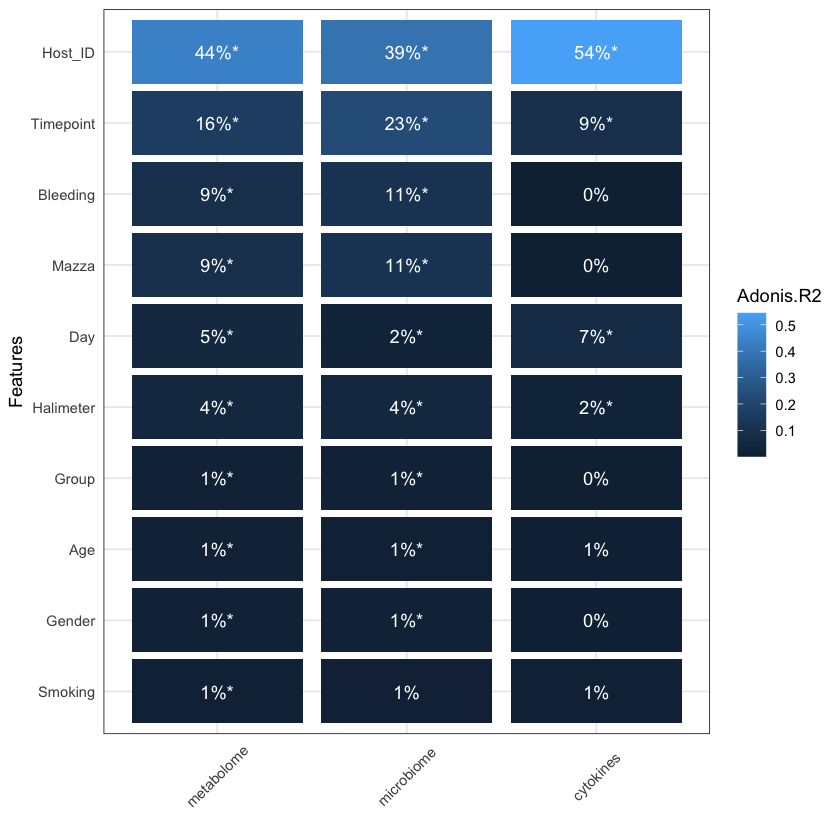

In [32]:
p<-ggplot(stat_summ_all, aes(x=omics, y=reorder(feature, Adonis.R2))) + 
  geom_tile(aes(fill=Adonis.R2, width=0.9, height=0.9), size=1)+ #color = Adonis.sig, 
  theme(axis.text.x=element_text(angle=90,hjust=1), panel.border = element_blank())+
  #scale_color_manual(values=c("white","grey80"))+
  ylab("Features")+
  xlab("")+
  geom_text(aes(label = paste(round(Adonis.R2, 2)*100, "%", ifelse(Adonis.sig=="TRUE", "*", ""),  sep="" )), color = "white") +
  #scale_fill_viridis()+ 
  theme_bw()+
  theme(axis.line = element_blank(), axis.text.x = element_text(angle = 45, vjust = 0.5),
        axis.ticks = element_blank())
p
ggsave(filename=paste(outpath,"/Adonis.R2_by_omics.heatmap.pdf",sep=""), plot=p, width=4, height=5)

In [33]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS  10.14.6

Matrix products: default
BLAS/LAPACK: /Users/huangshi/anaconda3/envs/r-env/lib/R/lib/libRblas.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggridges_0.5.2      igraph_1.2.2        optparse_1.6.4     
 [4] combinat_0.0-8      reshape_0.8.8       gridExtra_2.3      
 [7] cowplot_1.0.0       pROC_1.16.1         corrplot_0.84      
[10] plotly_4.9.1        clusterSim_0.48-1   MASS_7.3-51.4      
[13] cluster_2.1.0       ape_5.3             randomForest_4.6-14
[16] dplyr_0.8.3         pheatmap_1.0.12     ggplot2_3.3.0      
[19] reshape2_1.4.3      ade4_1.7-13         vegan_2.5-6        
[22] lattice_0.20-38     permute_0.9-5      

loaded via a namespace (and not attached):
 [1] httr_1.4.1              tidyr_1.